# AI Personality Drift Simulation - Persona Baseline Analysis 
This notebook analyzes the baseline characteristics of our AI personas, including:
- Personality trait distributions
- Clinical baseline scores
- Persona demographics and characteristics
- Baseline reliability and validity checks
 
**Author**: Mike Keeman  
**Date**: July 2025

In [2]:
import sys
import os
sys.path.append('../../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime

# Analysis imports
from analysis.statistical_analyzer import StatisticalAnalyzer
from analysis.visualization_toolkit import VisualizationToolkit
from analysis.data_export import DataExporter

# Model imports
from models import Persona, PersonaBaseline, PersonaState
from models.persona import PersonalityTrait

In [3]:
# Setup plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Initialize analysis tools
stats_analyzer = StatisticalAnalyzer()
viz_toolkit = VisualizationToolkit(style="publication")
data_exporter = DataExporter()

In [4]:
# Create output directory
output_dir = Path("../../data/results/baseline_analysis")
output_dir.mkdir(parents=True, exist_ok=True)

## Load Persona Data

In [5]:
# Load persona configurations
config_dir = Path("../../config/personas")
persona_files = list(config_dir.glob("*.yaml"))

print(f"Found {len(persona_files)} persona configuration files:")
for file in persona_files:
    print(f"  - {file.name}")

Found 4 persona configuration files:
  - alfred_baseline.yaml
  - test_persona_baseline.yaml
  - kara_baseline.yaml
  - marcus_baseline.yaml


In [11]:
# Load and parse persona data
import yaml

personas = []
for file in persona_files:
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    
    # Create PersonaBaseline
    baseline = PersonaBaseline(**config)
    
    # Create PersonaState (initial state)
    state = PersonaState(
        persona_id=baseline.name.lower().replace(" ", "_"),
        simulation_day=0,
        last_assessment_day=-1,
        current_phq9=baseline.baseline_phq9,
        current_gad7=baseline.baseline_gad7,
        current_pss10=baseline.baseline_pss10,
        drift_magnitude=0.0,
        emotional_state="neutral",
        stress_level=0.0
    )
    
    # Create Persona
    persona = Persona(baseline=baseline, state=state)
    # exclude test persona (its for dev)
    if persona.baseline.name != "Test Persona":
        personas.append(persona)

print(f"Loaded {len(personas)} personas:")
for persona in personas:
    print(f"  - {persona.baseline.name} (ID: {persona.state.persona_id})")

Loaded 3 personas:
  - Alfred (ID: alfred)
  - Kara (ID: kara)
  - Marcus (ID: marcus)


## Personality Trait Analysis

In [9]:
# Extract personality traits for analysis
trait_data = []
for persona in personas:
    traits = persona.baseline.get_traits_dict()
    traits['persona_id'] = persona.state.persona_id
    traits['name'] = persona.baseline.name
    traits['age'] = persona.baseline.age
    traits['occupation'] = persona.baseline.occupation
    trait_data.append(traits)

trait_df = pd.DataFrame(trait_data)
print("Personality trait summary:")
print(trait_df.describe())

Personality trait summary:
       openness  conscientiousness  extraversion  agreeableness  neuroticism  \
count  3.000000           3.000000      3.000000       3.000000     3.000000   
mean   0.600000           0.766667      0.500000       0.633333     0.433333   
std    0.264575           0.152753      0.360555       0.152753     0.152753   
min    0.300000           0.600000      0.200000       0.500000     0.300000   
25%    0.500000           0.700000      0.300000       0.550000     0.350000   
50%    0.700000           0.800000      0.400000       0.600000     0.400000   
75%    0.750000           0.850000      0.650000       0.700000     0.500000   
max    0.800000           0.900000      0.900000       0.800000     0.600000   

             age  
count   3.000000  
mean   35.000000  
std     8.888194  
min    28.000000  
25%    30.000000  
50%    32.000000  
75%    38.500000  
max    45.000000  


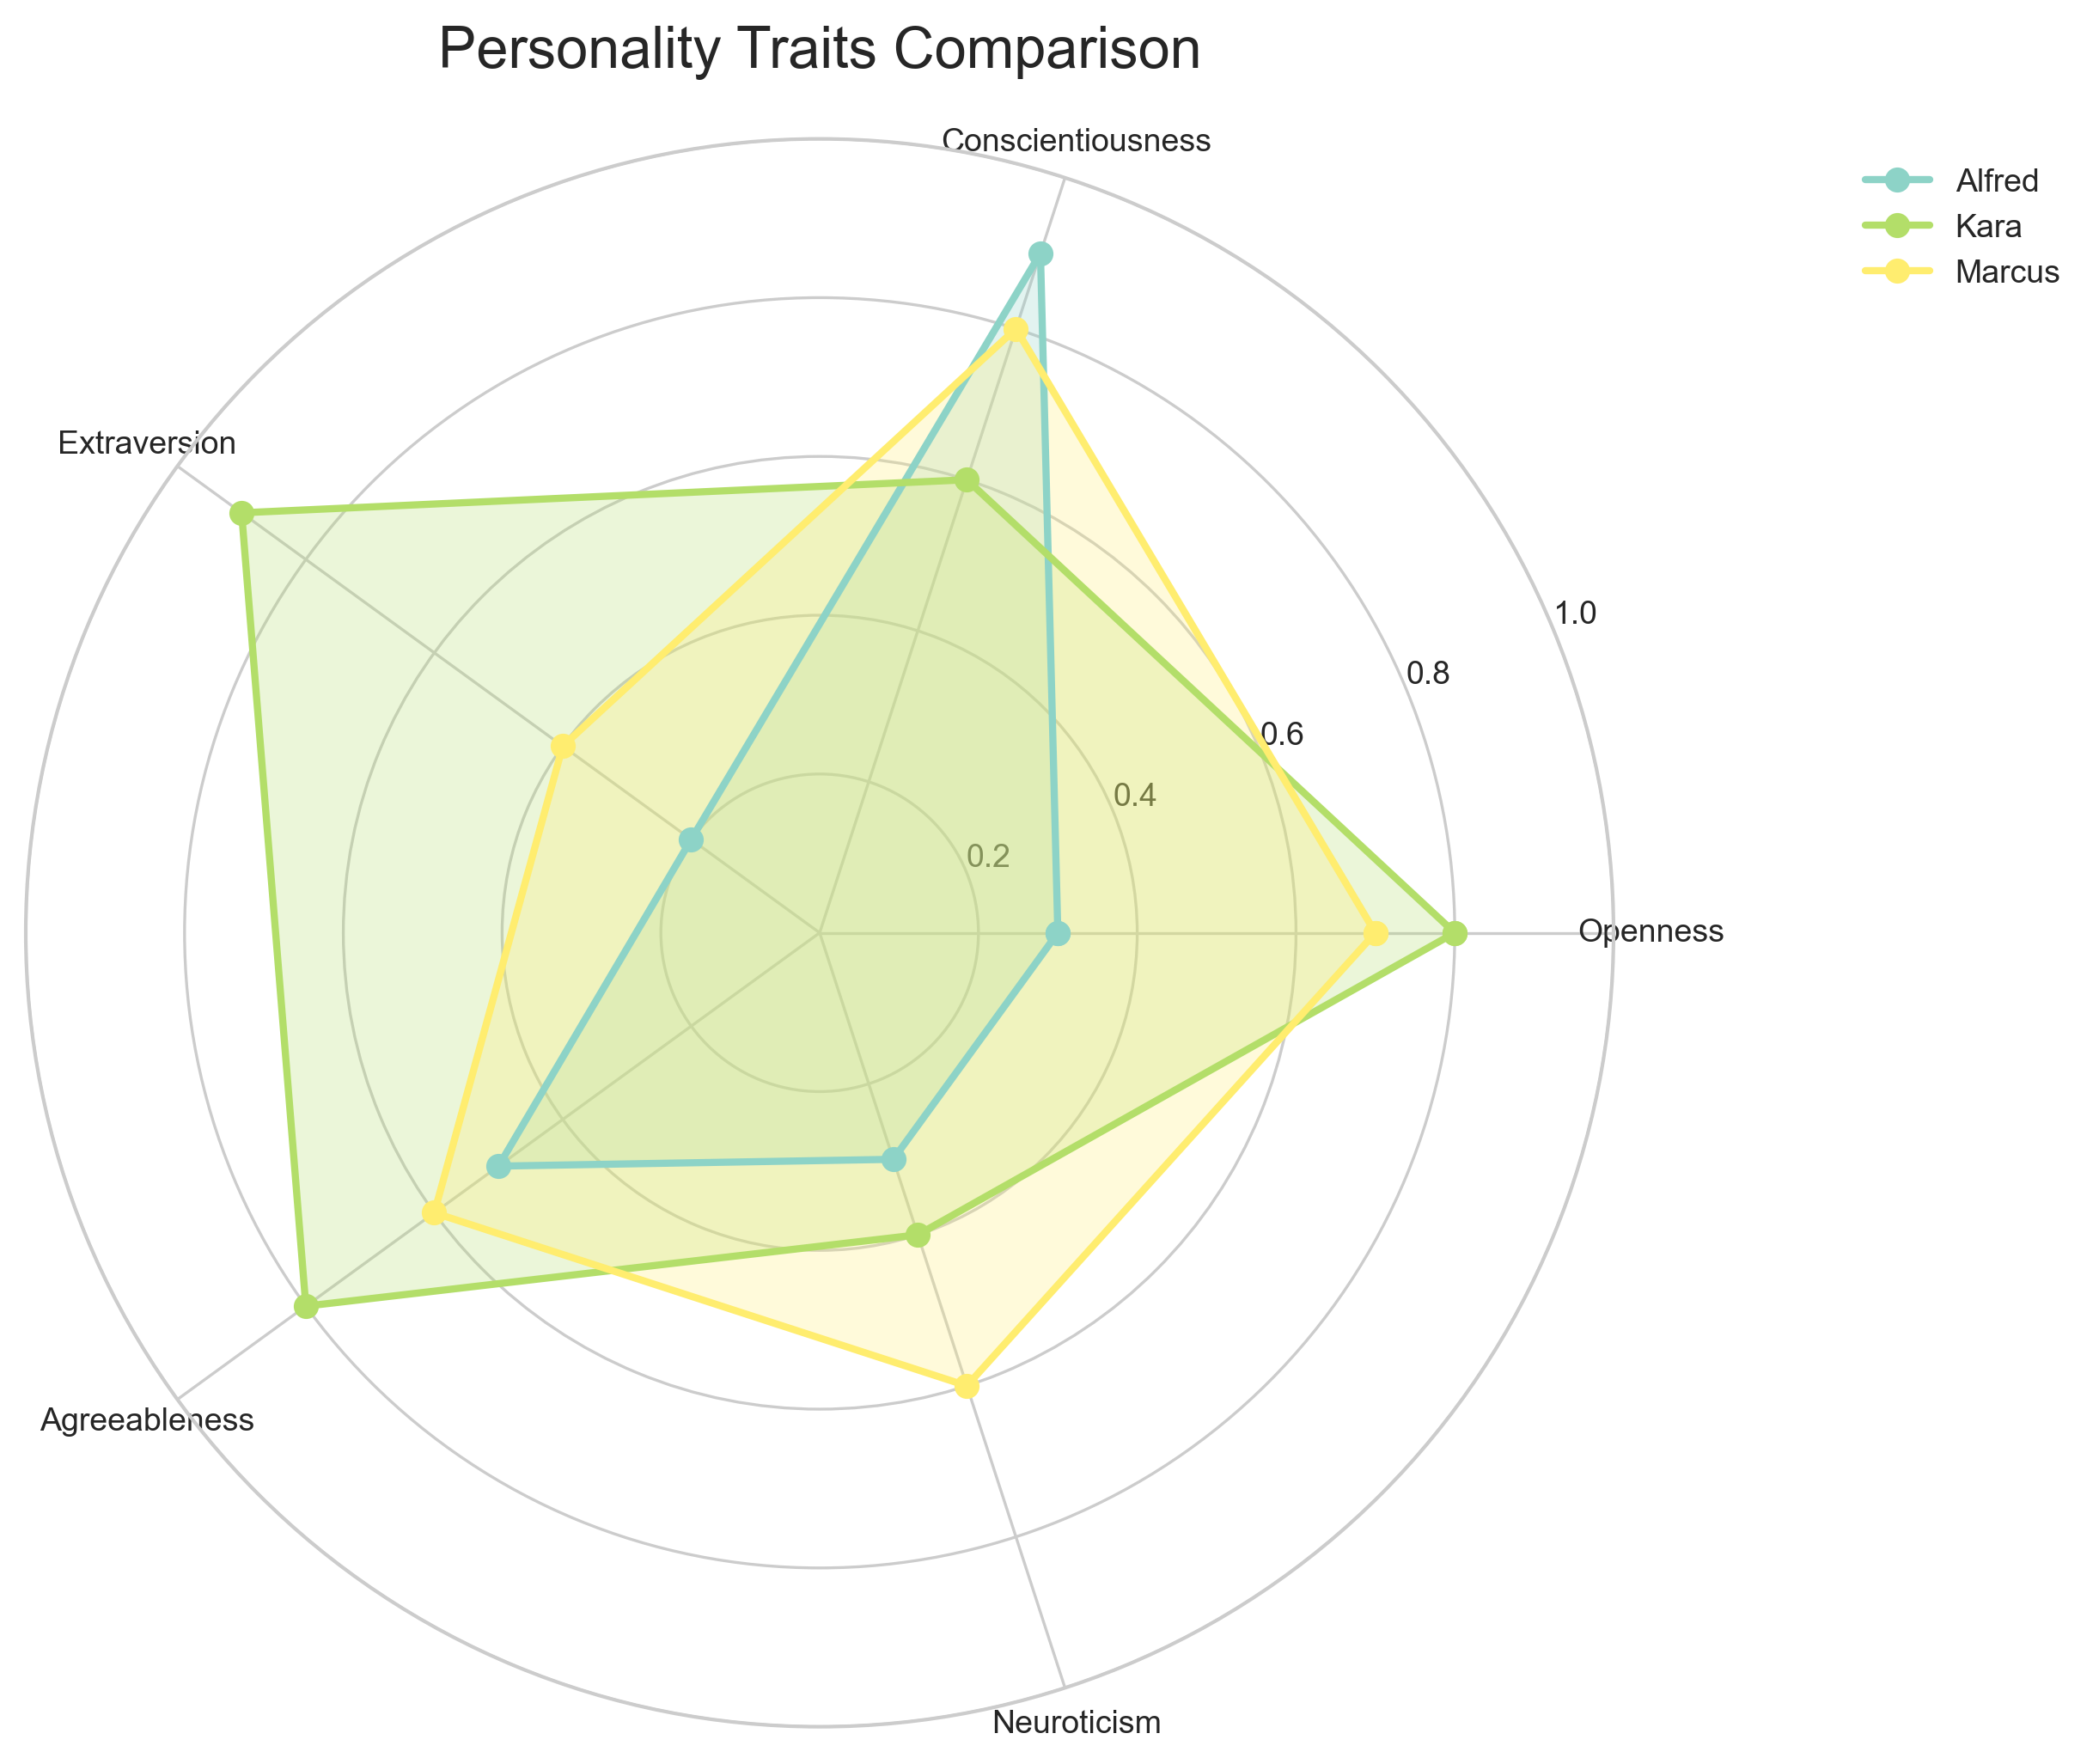

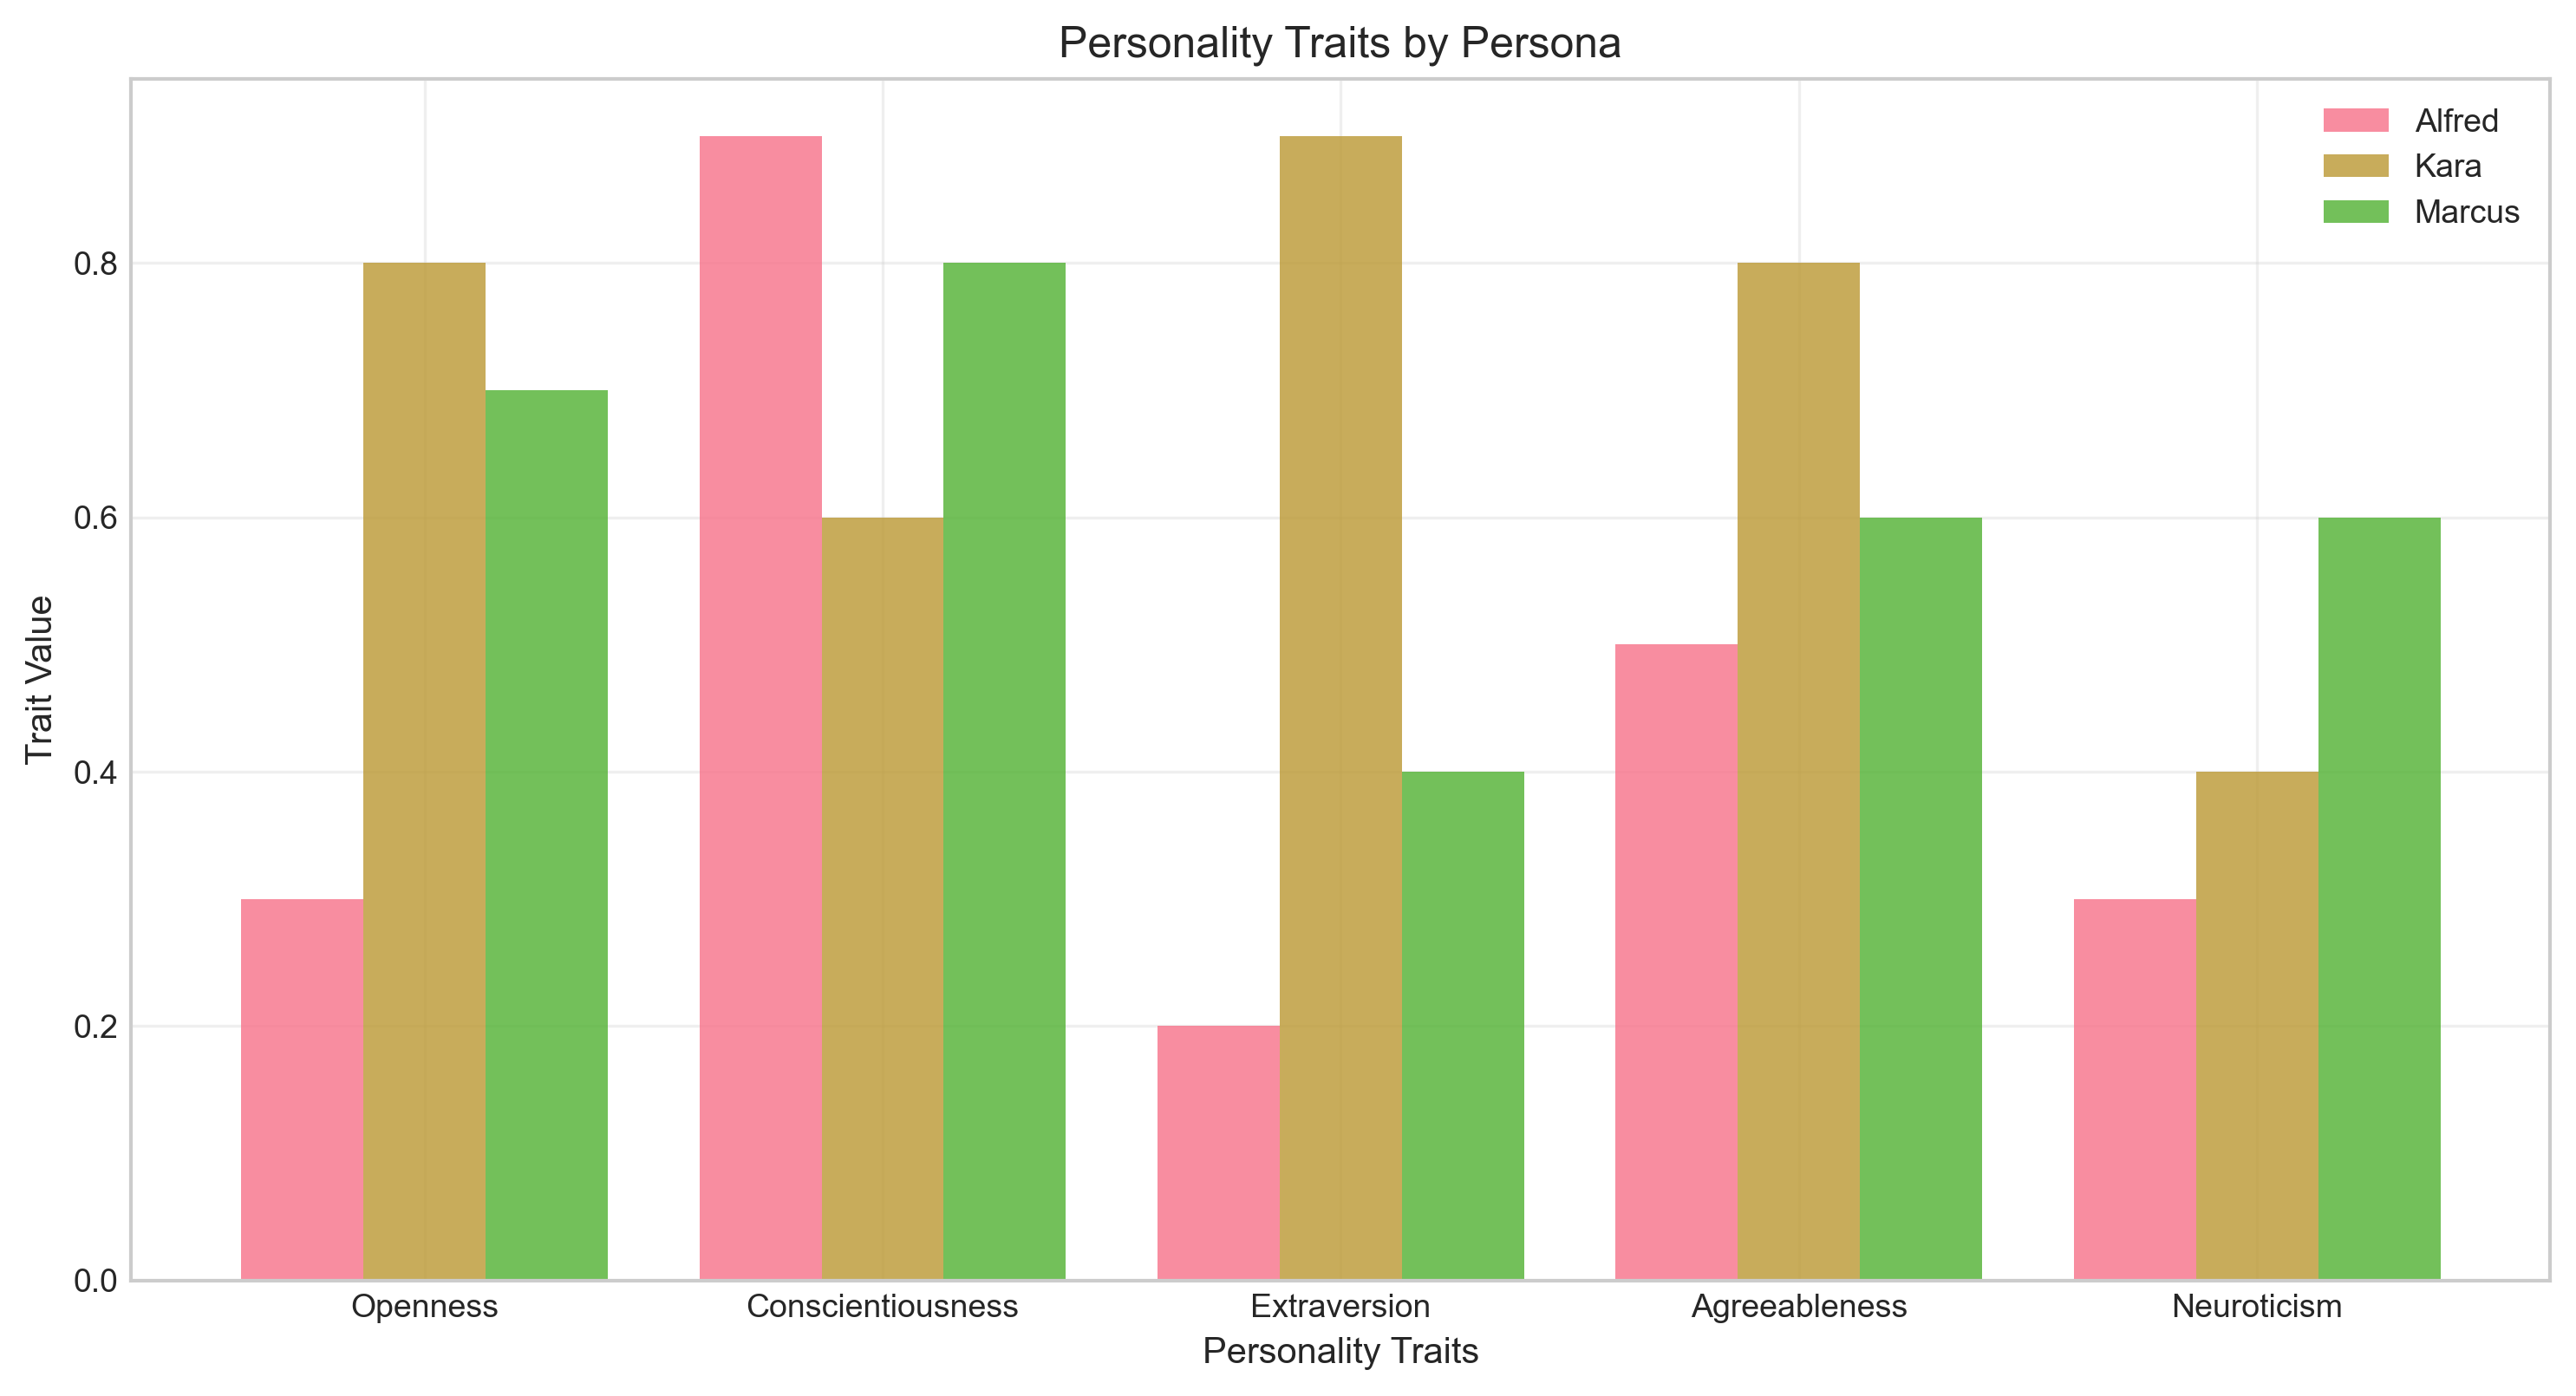

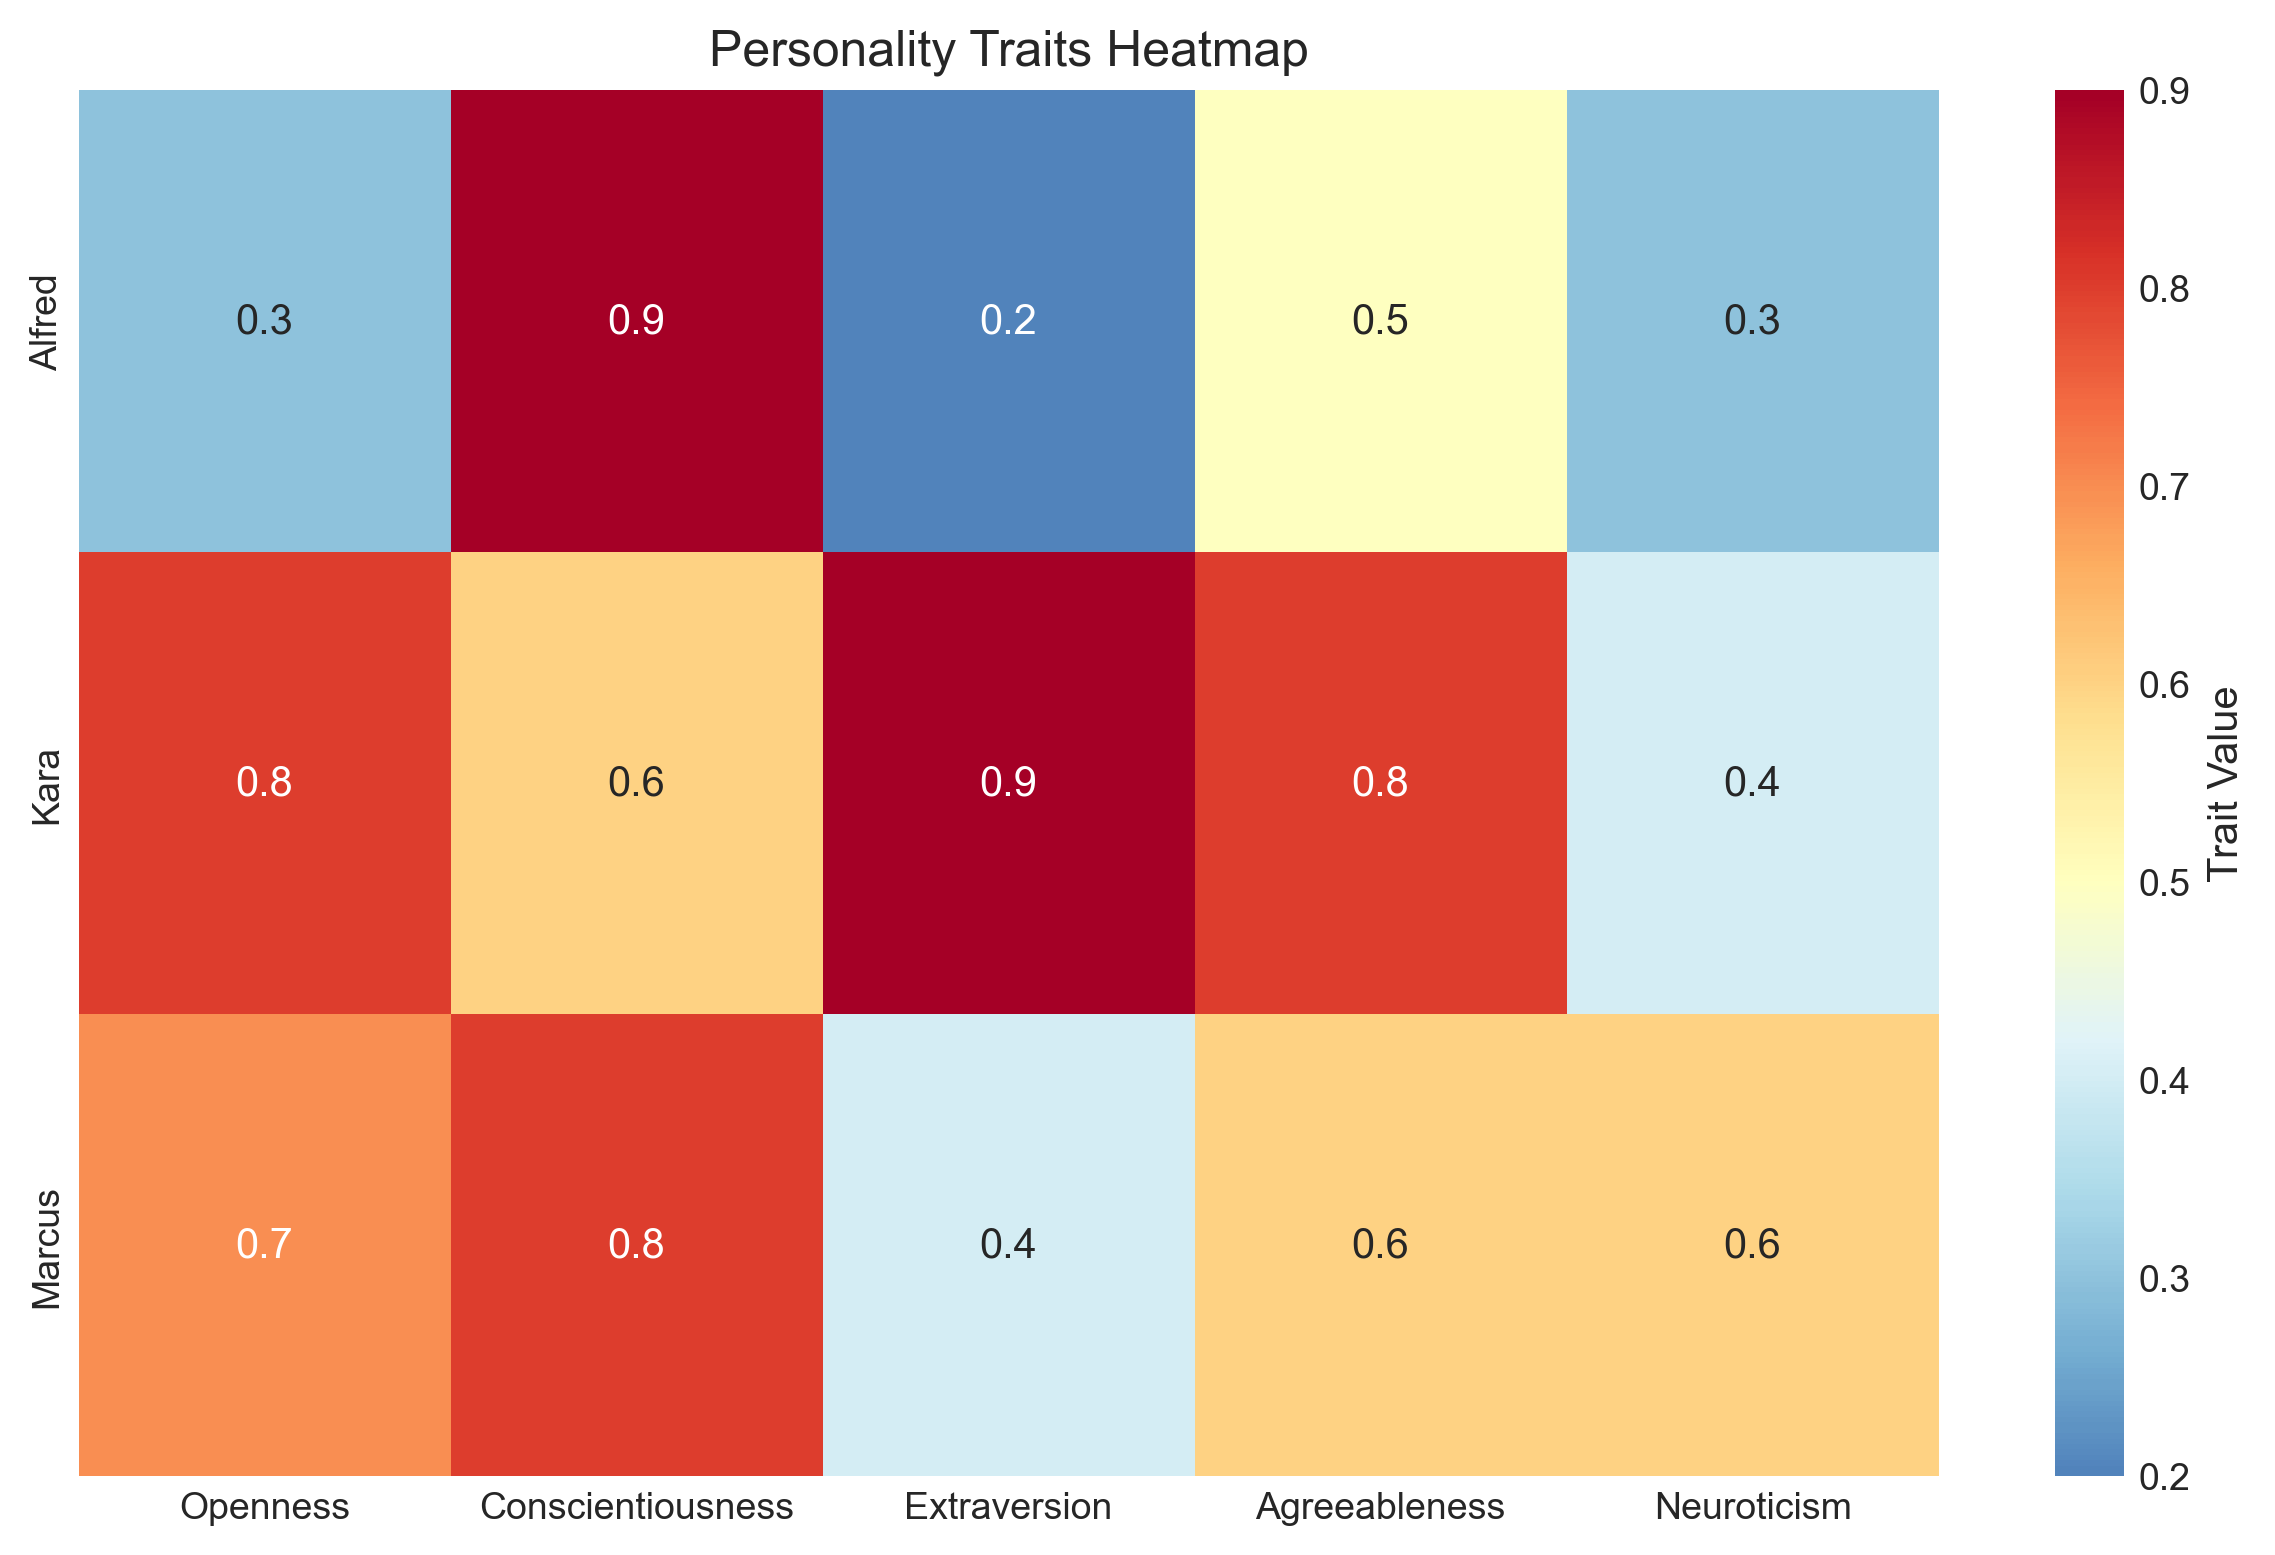

In [12]:
# Visualize personality traits
fig = viz_toolkit.plot_personality_traits(personas, plot_type="radar")
plt.savefig(output_dir / "personality_traits_radar.png", bbox_inches='tight')
plt.show()

# %%
# Bar plot of personality traits
fig = viz_toolkit.plot_personality_traits(personas, plot_type="bar")
plt.savefig(output_dir / "personality_traits_bar.png", bbox_inches='tight')
plt.show()

# %%
# Heatmap of personality traits
fig = viz_toolkit.plot_personality_traits(personas, plot_type="heatmap")
plt.savefig(output_dir / "personality_traits_heatmap.png", bbox_inches='tight')
plt.show()

## Clinical Baseline Analysis

In [13]:
# Extract clinical baseline scores
clinical_data = []
for persona in personas:
    clinical_data.append({
        'persona_id': persona.state.persona_id,
        'name': persona.baseline.name,
        'phq9_baseline': persona.baseline.baseline_phq9,
        'gad7_baseline': persona.baseline.baseline_gad7,
        'pss10_baseline': persona.baseline.baseline_pss10,
        'age': persona.baseline.age,
        'occupation': persona.baseline.occupation
    })

clinical_df = pd.DataFrame(clinical_data)
print("Clinical baseline summary:")
print(clinical_df.describe())

Clinical baseline summary:
       phq9_baseline  gad7_baseline  pss10_baseline        age
count       3.000000            3.0        3.000000   3.000000
mean        3.666667            4.0       10.666667  35.000000
std         2.081666            1.0        3.055050   8.888194
min         2.000000            3.0        8.000000  28.000000
25%         2.500000            3.5        9.000000  30.000000
50%         3.000000            4.0       10.000000  32.000000
75%         4.500000            4.5       12.000000  38.500000
max         6.000000            5.0       14.000000  45.000000


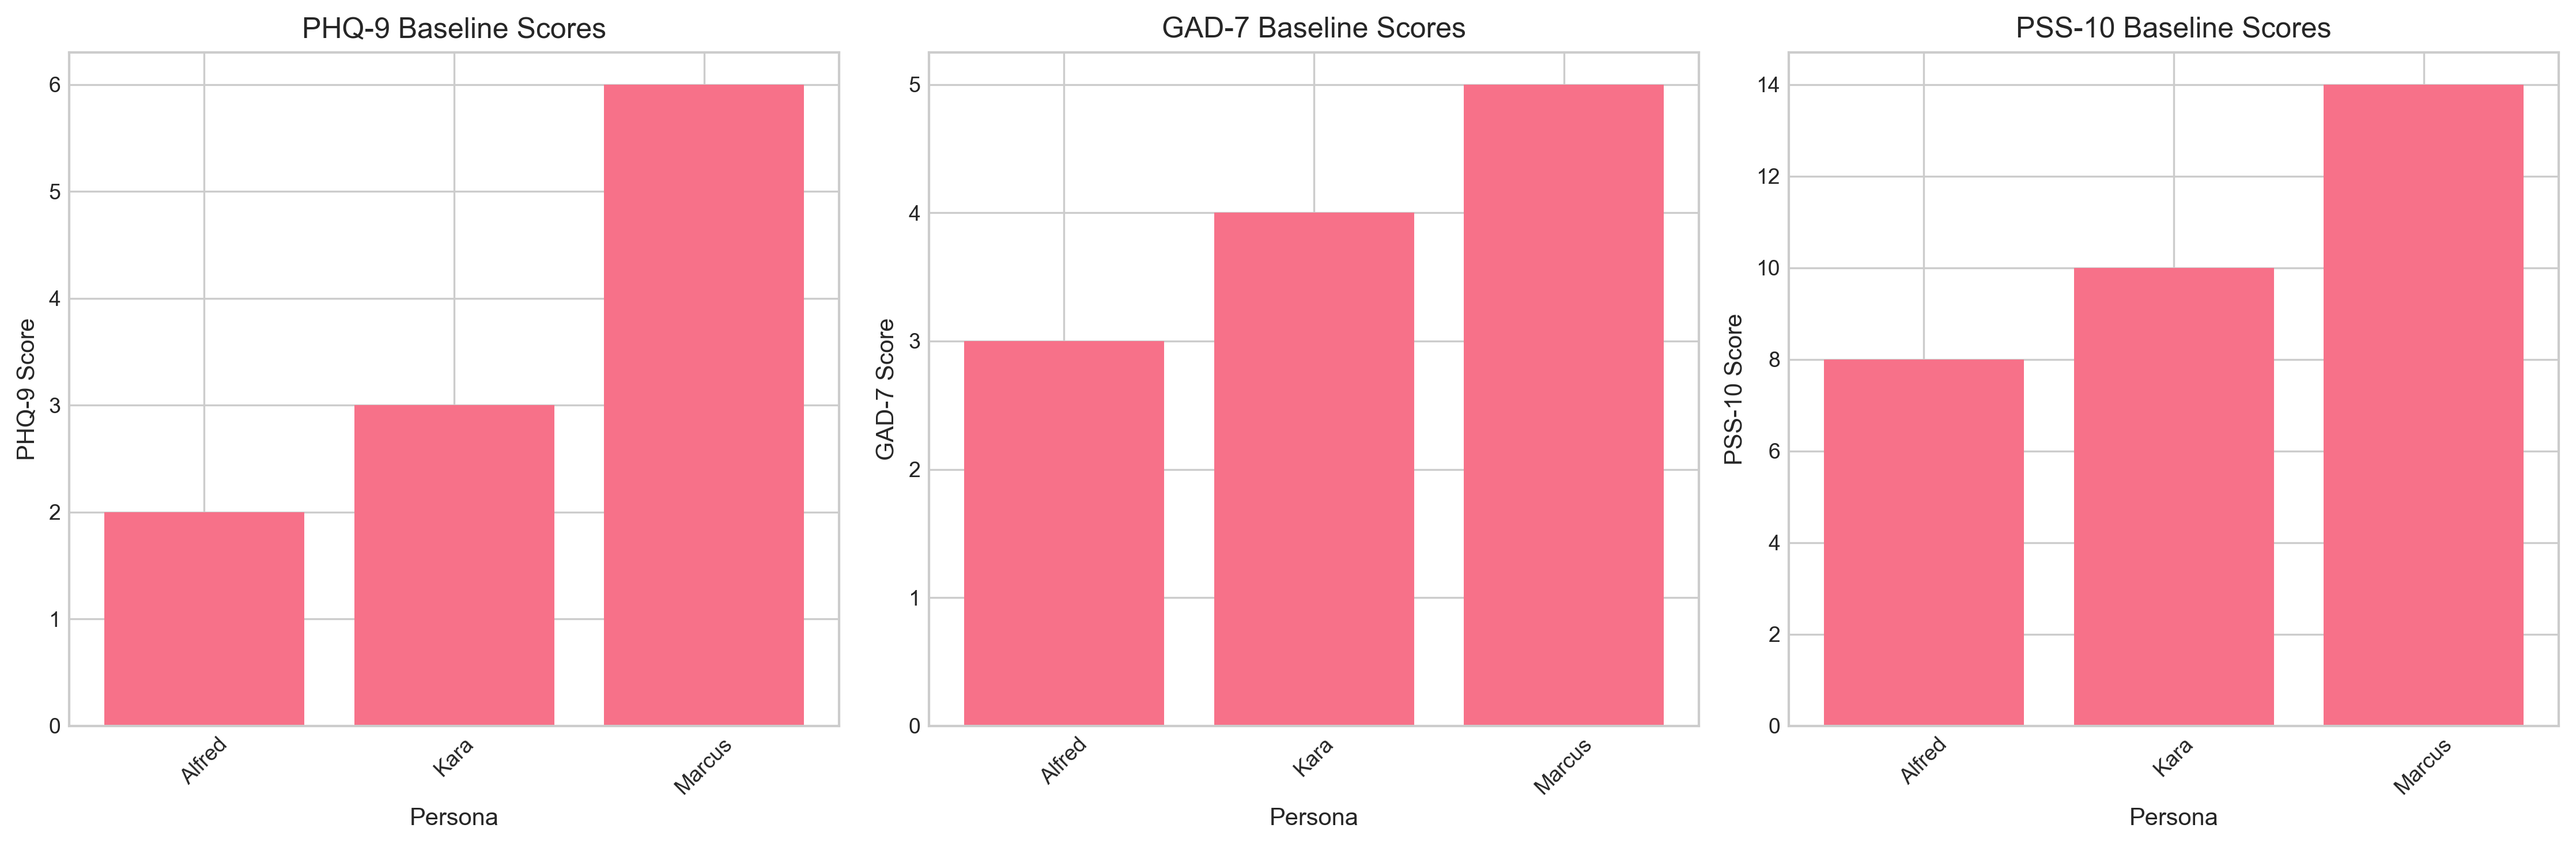

In [14]:
# Visualize clinical baseline scores
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# PHQ-9 baseline
axes[0].bar(range(len(clinical_df)), clinical_df['phq9_baseline'])
axes[0].set_title('PHQ-9 Baseline Scores')
axes[0].set_xlabel('Persona')
axes[0].set_ylabel('PHQ-9 Score')
axes[0].set_xticks(range(len(clinical_df)))
axes[0].set_xticklabels(clinical_df['name'], rotation=45)

# GAD-7 baseline
axes[1].bar(range(len(clinical_df)), clinical_df['gad7_baseline'])
axes[1].set_title('GAD-7 Baseline Scores')
axes[1].set_xlabel('Persona')
axes[1].set_ylabel('GAD-7 Score')
axes[1].set_xticks(range(len(clinical_df)))
axes[1].set_xticklabels(clinical_df['name'], rotation=45)

# PSS-10 baseline
axes[2].bar(range(len(clinical_df)), clinical_df['pss10_baseline'])
axes[2].set_title('PSS-10 Baseline Scores')
axes[2].set_xlabel('Persona')
axes[2].set_ylabel('PSS-10 Score')
axes[2].set_xticks(range(len(clinical_df)))
axes[2].set_xticklabels(clinical_df['name'], rotation=45)

plt.tight_layout()
plt.savefig(output_dir / "clinical_baseline_scores.png", bbox_inches='tight')
plt.show()

## Correlation Analysis

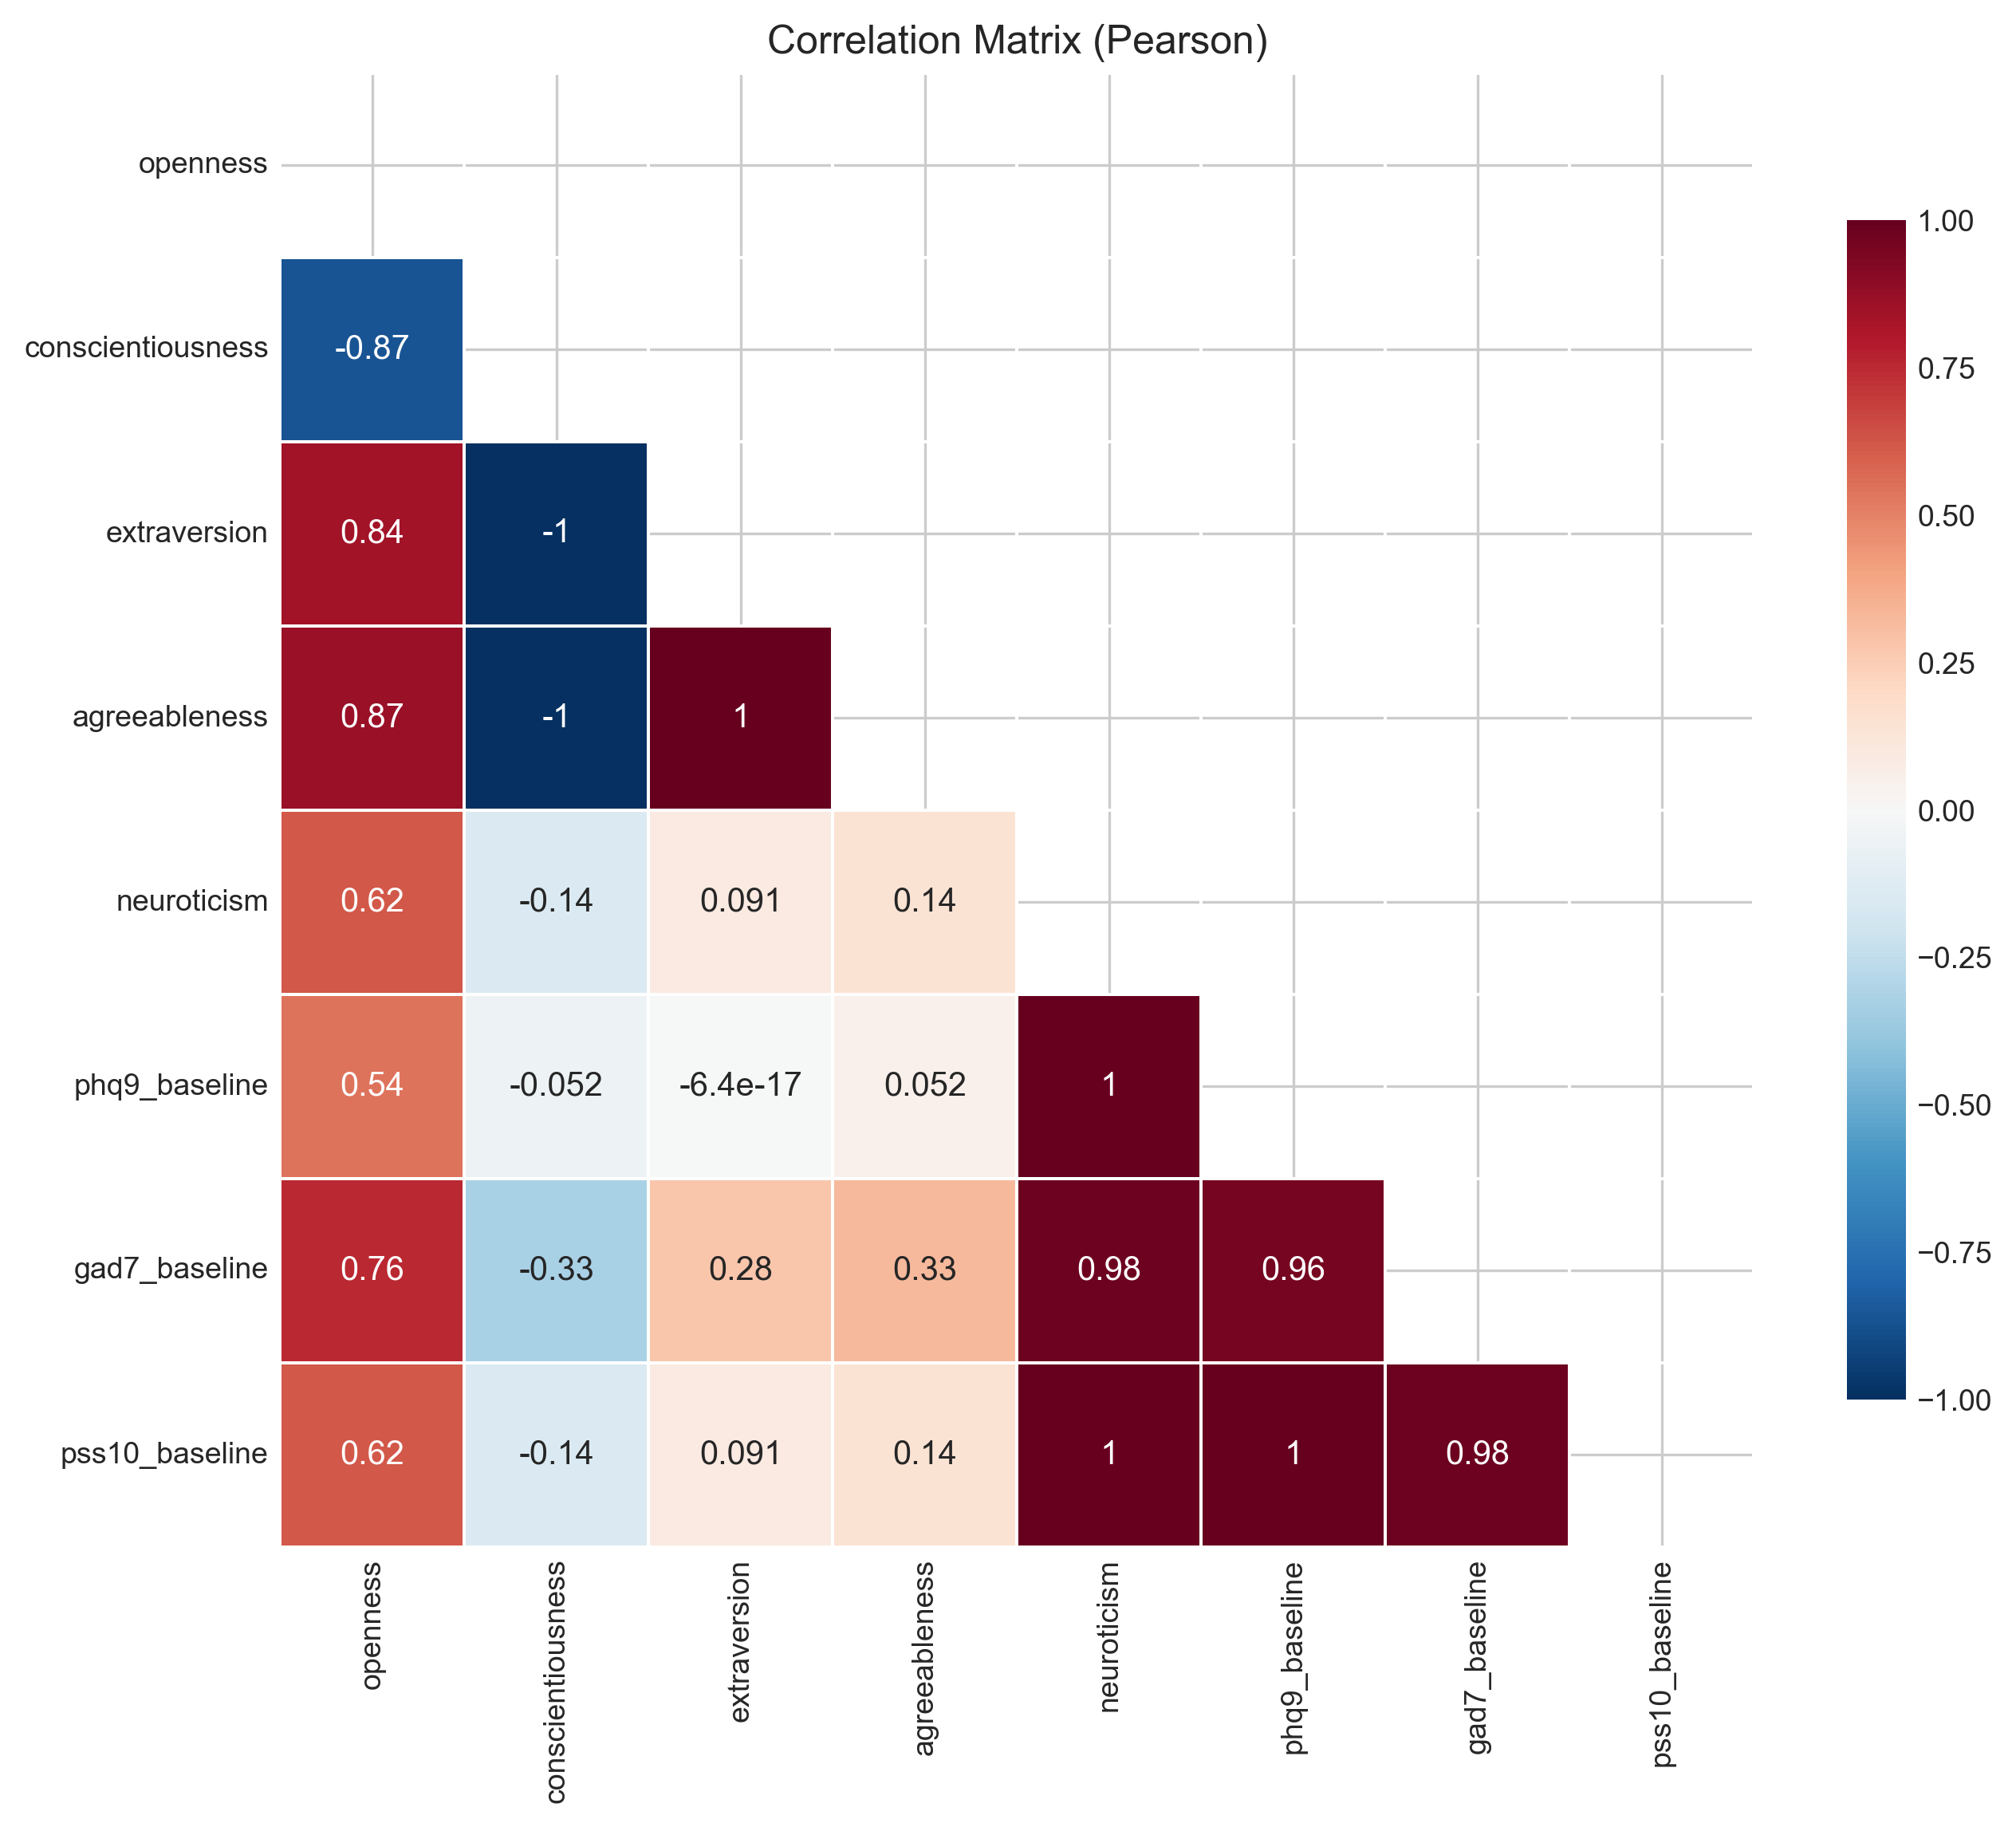

Correlation analysis between personality traits and clinical scores:
Openness vs PHQ9:
  Correlation: 0.545
  P-value: 0.633
  Significant: False
  Strength: large

Openness vs GAD7:
  Correlation: 0.756
  P-value: 0.454
  Significant: False
  Strength: large

Openness vs PSS10:
  Correlation: 0.619
  P-value: 0.575
  Significant: False
  Strength: large

Conscientiousness vs PHQ9:
  Correlation: -0.052
  P-value: 0.967
  Significant: False
  Strength: negligible

Conscientiousness vs GAD7:
  Correlation: -0.327
  P-value: 0.788
  Significant: False
  Strength: medium

Conscientiousness vs PSS10:
  Correlation: -0.143
  P-value: 0.909
  Significant: False
  Strength: small

Extraversion vs PHQ9:
  Correlation: 0.000
  P-value: 1.000
  Significant: False
  Strength: negligible

Extraversion vs GAD7:
  Correlation: 0.277
  P-value: 0.821
  Significant: False
  Strength: small

Extraversion vs PSS10:
  Correlation: 0.091
  P-value: 0.942
  Significant: False
  Strength: negligible

Agreea

In [15]:
# Analyze correlations between personality traits and clinical scores
correlation_vars = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism',
                   'phq9_baseline', 'gad7_baseline', 'pss10_baseline']

correlation_data = trait_df.merge(clinical_df[['persona_id', 'phq9_baseline', 'gad7_baseline', 'pss10_baseline']], 
                                 on='persona_id')

# Create correlation matrix
corr_matrix = correlation_data[correlation_vars].corr()

# Visualize correlation matrix
fig = viz_toolkit.plot_correlation_matrix(correlation_data, variables=correlation_vars)
plt.savefig(output_dir / "personality_clinical_correlations.png", bbox_inches='tight')
plt.show()

# %%
# Statistical significance of correlations
print("Correlation analysis between personality traits and clinical scores:")
print("=" * 60)

for trait in ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']:
    for clinical in ['phq9_baseline', 'gad7_baseline', 'pss10_baseline']:
        correlation = stats_analyzer.correlation_analysis(
            correlation_data[trait].values,
            correlation_data[clinical].values,
            method="pearson"
        )
        
        print(f"{trait.title()} vs {clinical.replace('_baseline', '').upper()}:")
        print(f"  Correlation: {correlation['correlation']:.3f}")
        print(f"  P-value: {correlation['p_value']:.3f}")
        print(f"  Significant: {correlation['significant']}")
        print(f"  Strength: {correlation['strength']}")
        print()

## Demographics Analysis
> this is not super valuable for 3 personas experiment, but in large population of syntetic personas, and esp generated personalities, check demographics could serve as additiojnal sanity check (and if we consider multilingual-multicultural expriments - it becomes musthave part). MK

Persona demographics:
Name: Alfred
Age: 45
Occupation: Financial Analyst
--------------------
Name: Kara
Age: 32
Occupation: Marketing Manager
--------------------
Name: Marcus
Age: 28
Occupation: Software Engineer
--------------------


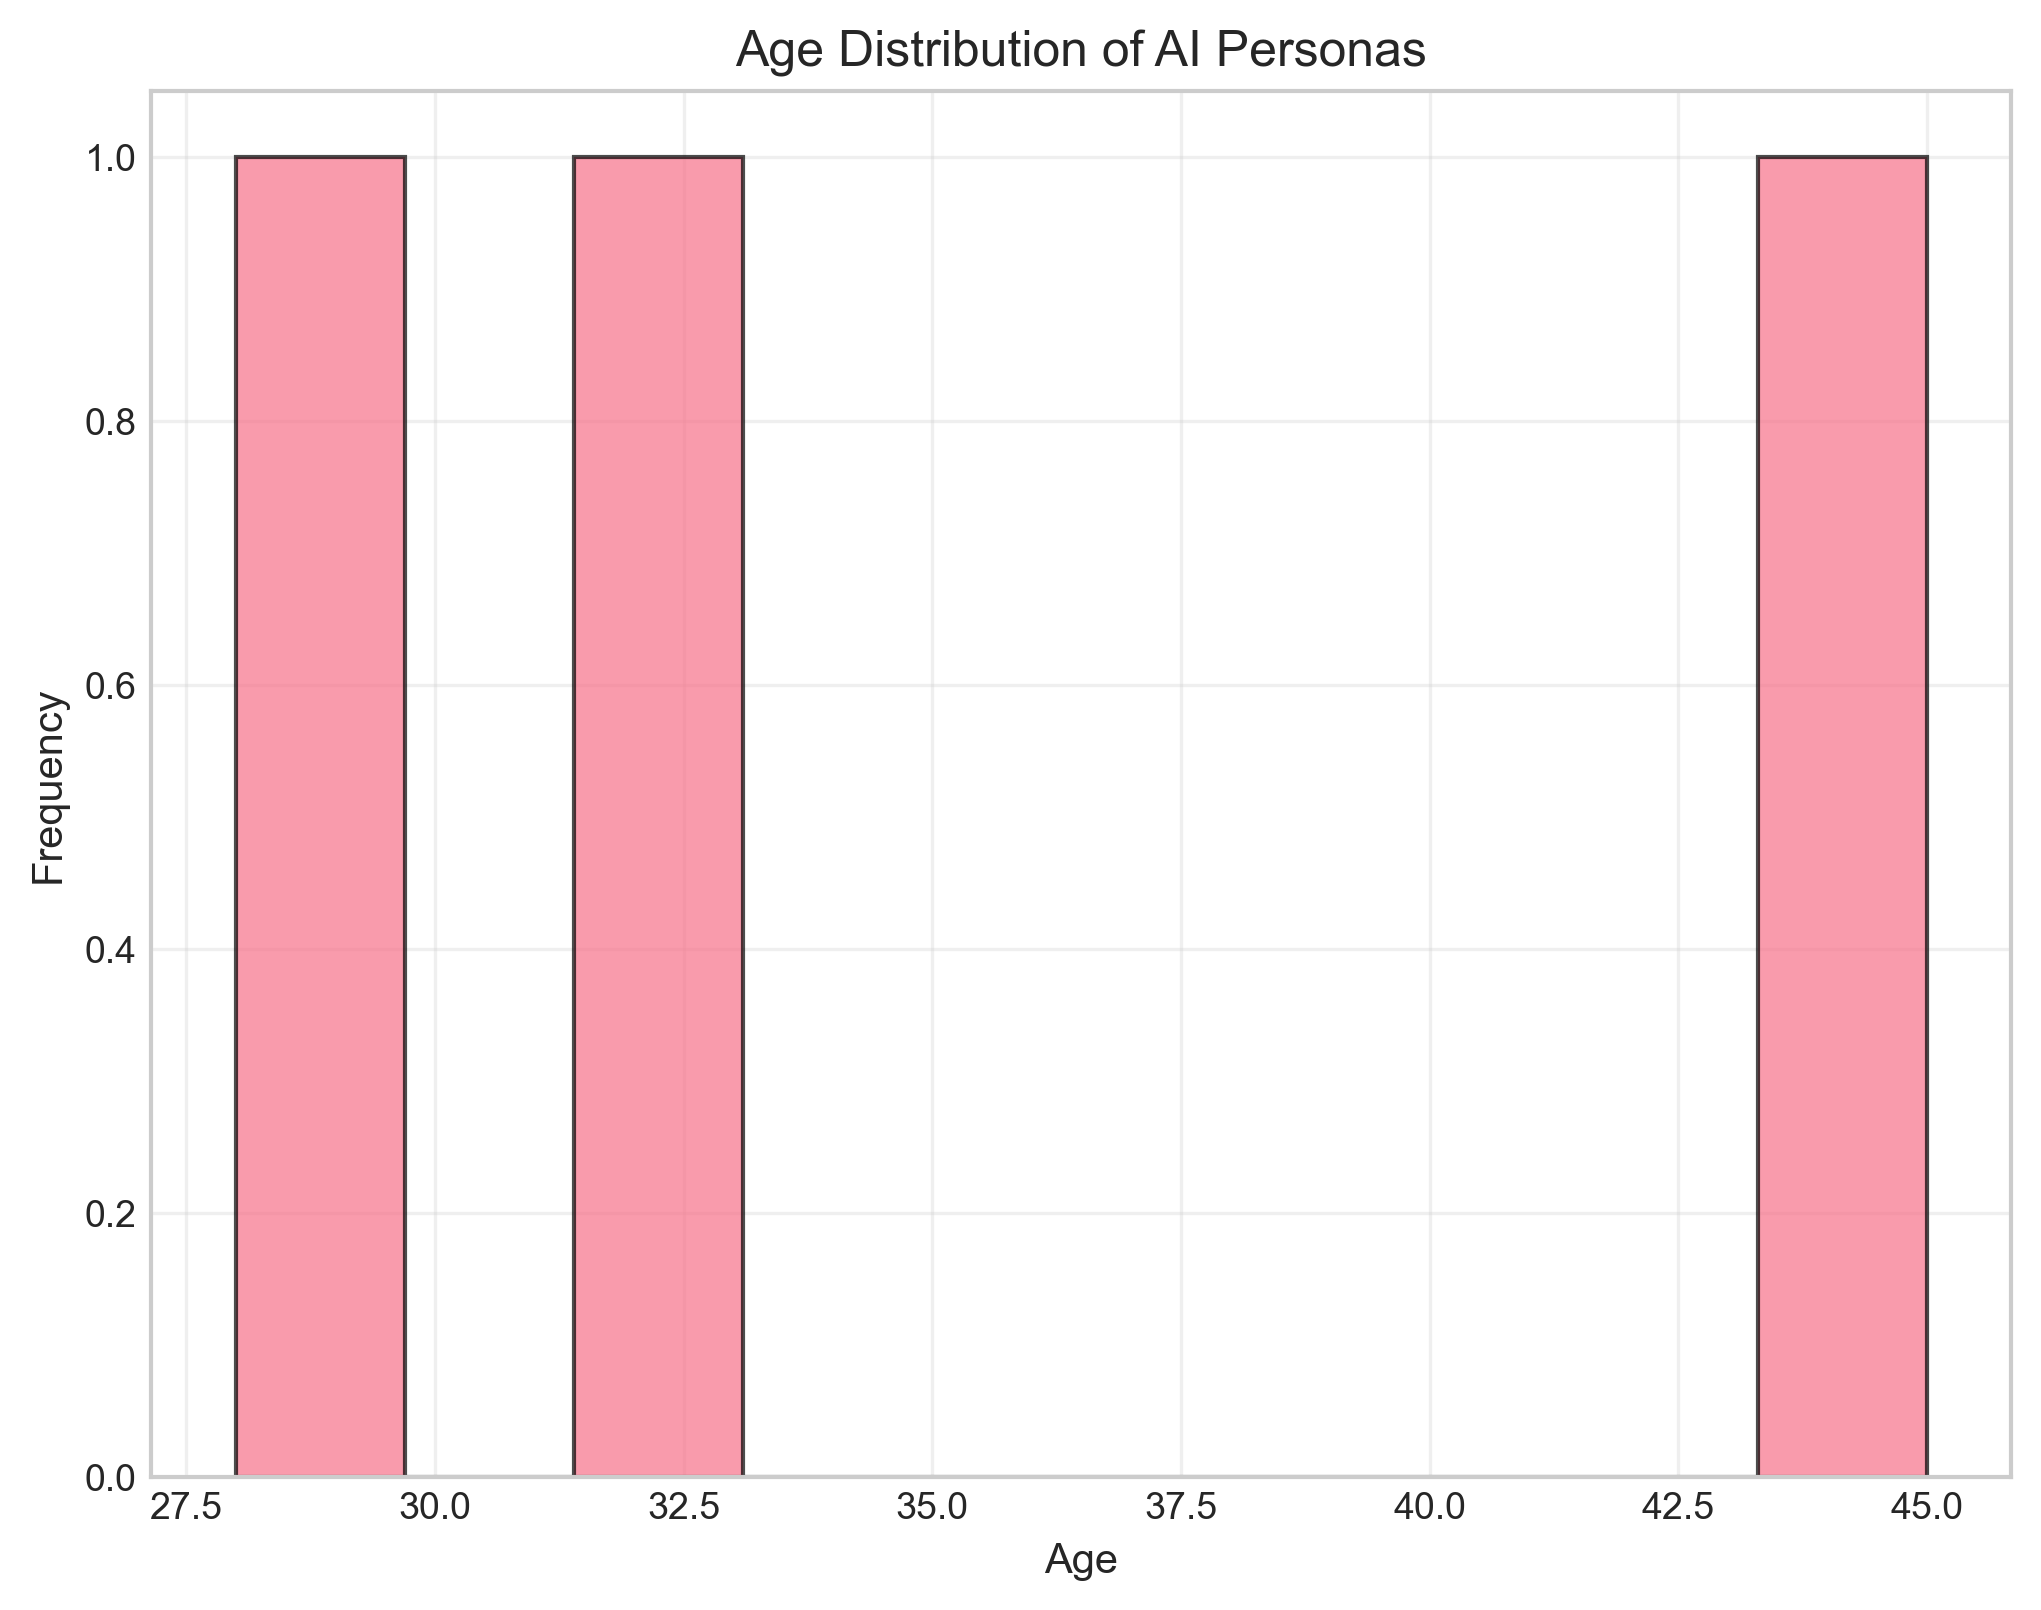

Occupation distribution:
occupation
Financial Analyst    1
Marketing Manager    1
Software Engineer    1
Name: count, dtype: int64


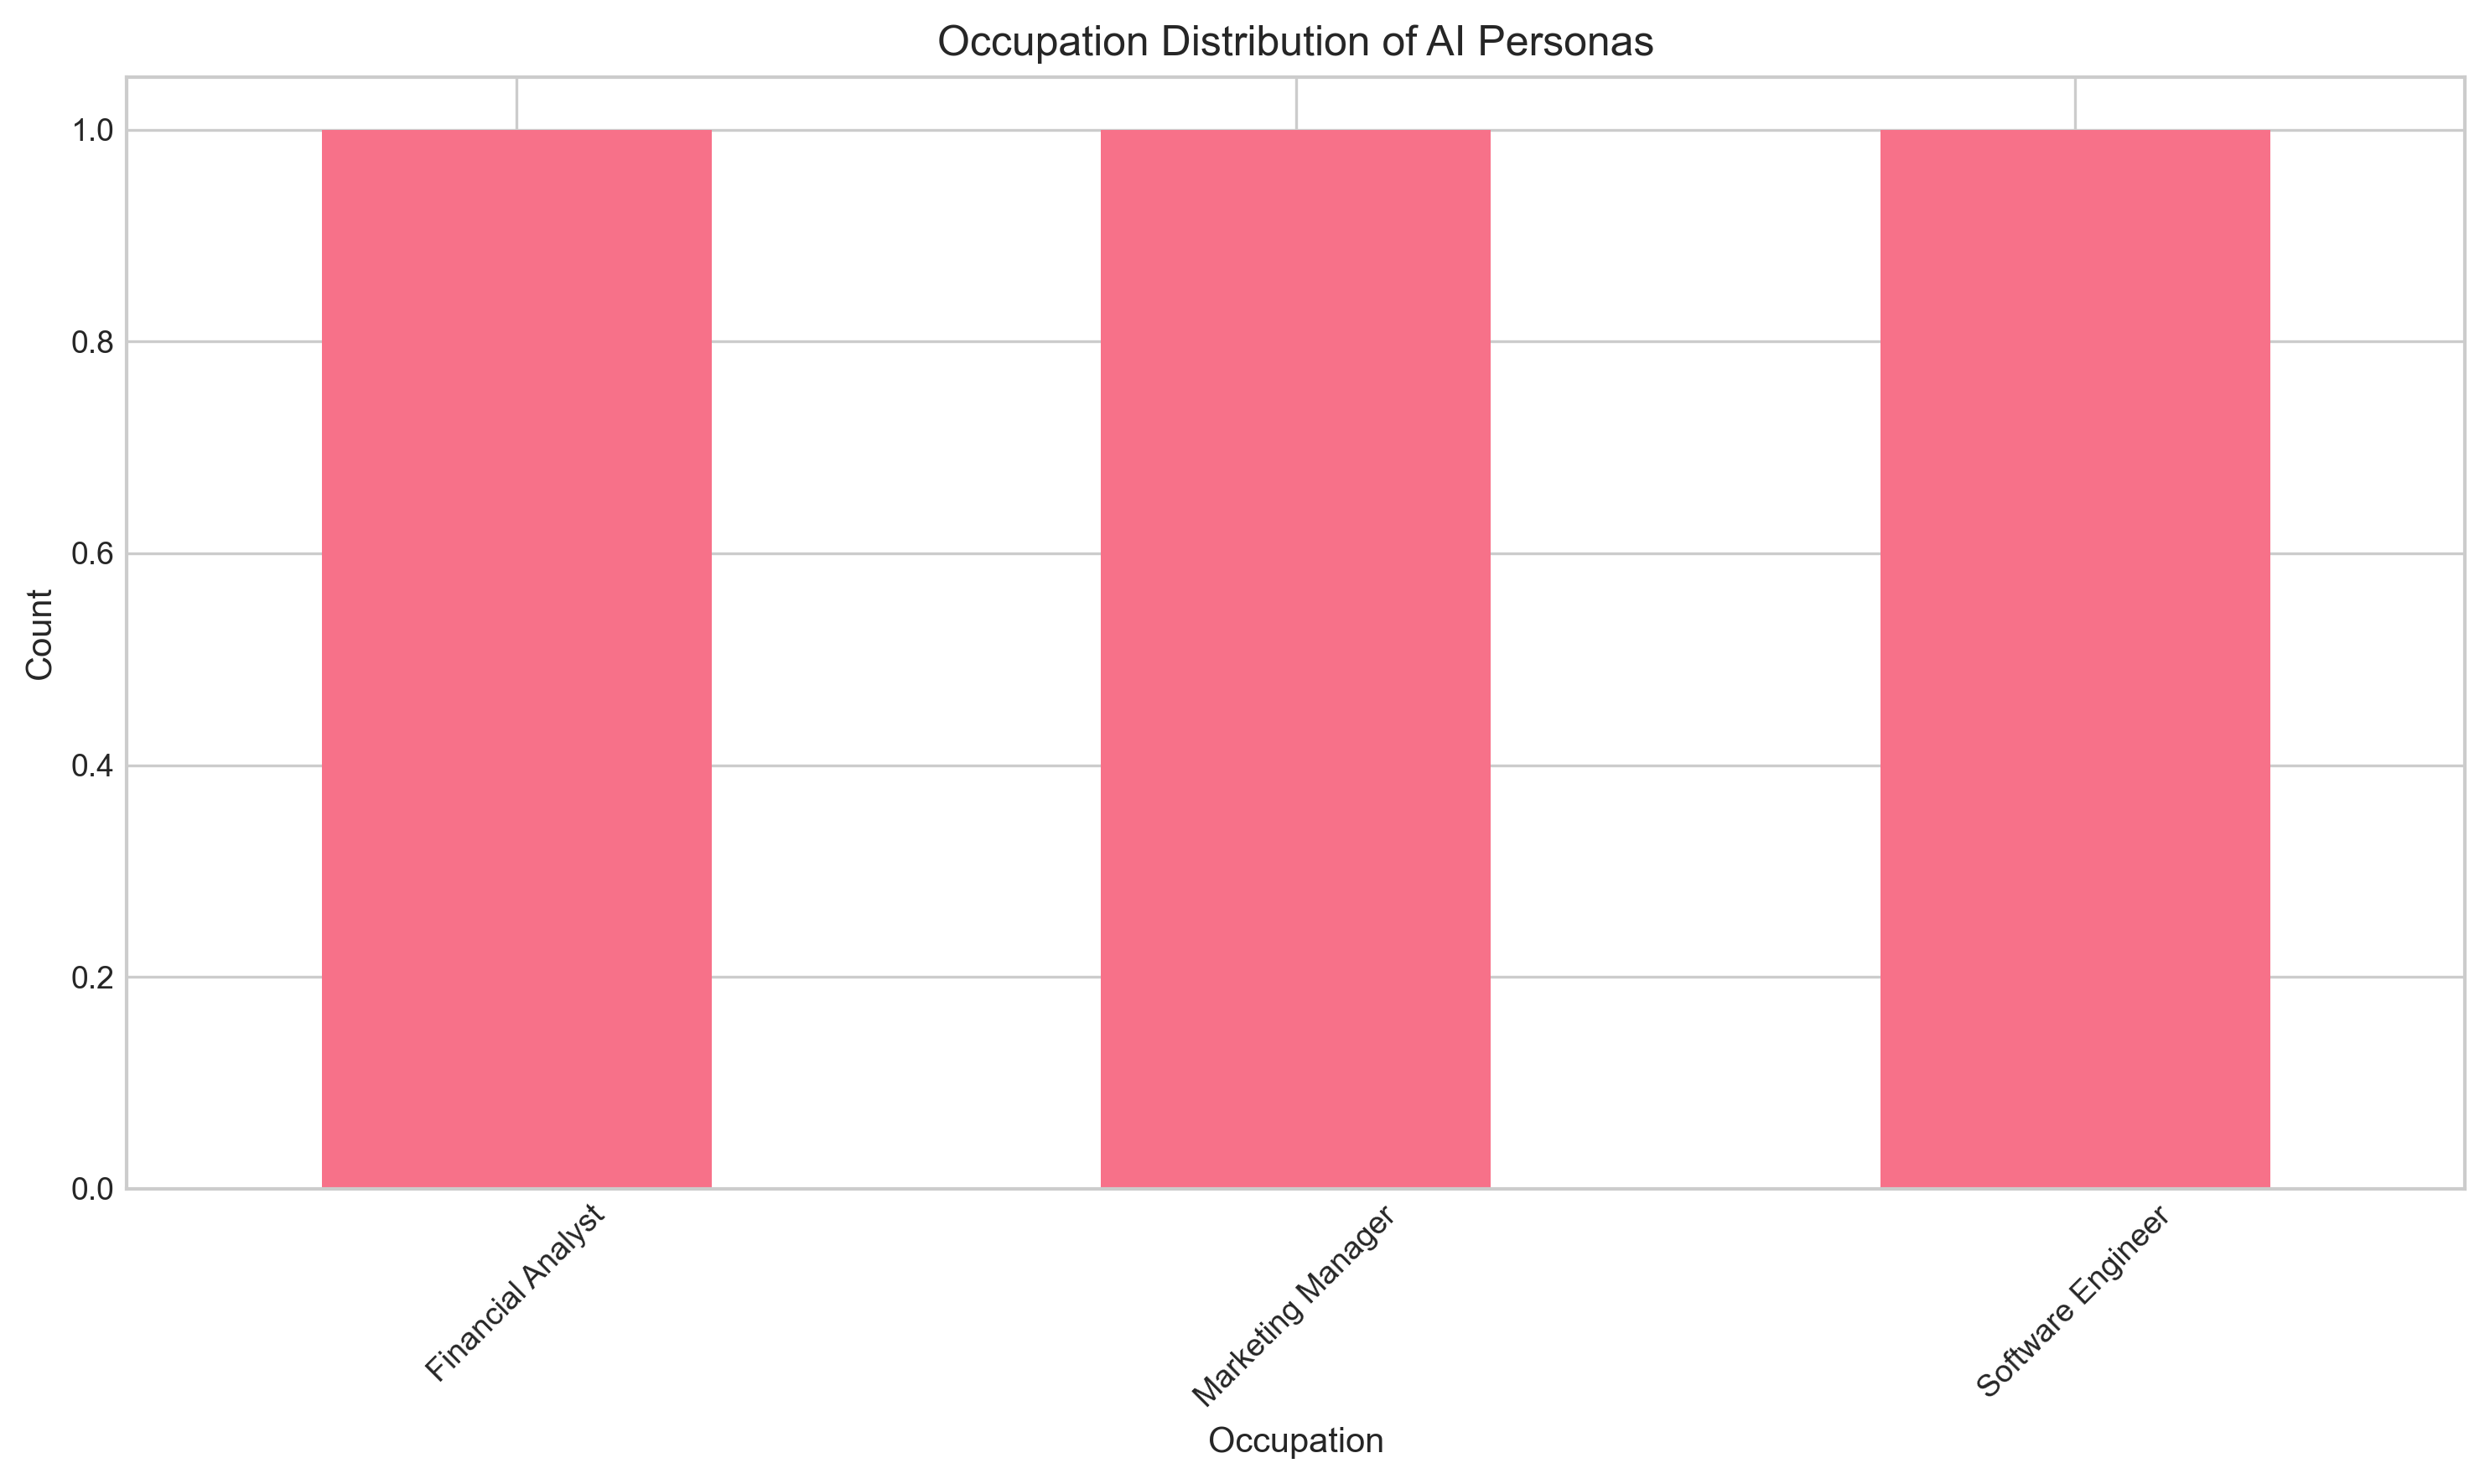

In [16]:
# Analyze persona demographics
demographics = clinical_df[['name', 'age', 'occupation']].copy()

print("Persona demographics:")
print("=" * 30)
for _, row in demographics.iterrows():
    print(f"Name: {row['name']}")
    print(f"Age: {row['age']}")
    print(f"Occupation: {row['occupation']}")
    print("-" * 20)

# %%
# Age distribution
plt.figure(figsize=(8, 6))
plt.hist(demographics['age'], bins=10, alpha=0.7, edgecolor='black')
plt.title('Age Distribution of AI Personas')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(output_dir / "age_distribution.png", bbox_inches='tight')
plt.show()

# %%
# Occupation analysis
occupation_counts = demographics['occupation'].value_counts()
print("Occupation distribution:")
print(occupation_counts)

plt.figure(figsize=(10, 6))
occupation_counts.plot(kind='bar')
plt.title('Occupation Distribution of AI Personas')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / "occupation_distribution.png", bbox_inches='tight')
plt.show()

## Baseline Reliability Analysis


In [17]:
# Analyze baseline consistency across personas
print("Baseline reliability analysis:")
print("=" * 40)

# Personality trait reliability (internal consistency across personas)
for trait in ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']:
    trait_values = trait_df[trait].values
    
    # Calculate coefficient of variation
    cv = np.std(trait_values) / np.mean(trait_values)
    
    print(f"{trait.title()}:")
    print(f"  Mean: {np.mean(trait_values):.3f}")
    print(f"  Std: {np.std(trait_values):.3f}")
    print(f"  CV: {cv:.3f}")
    print(f"  Range: {np.min(trait_values):.3f} - {np.max(trait_values):.3f}")
    print()

Baseline reliability analysis:
Openness:
  Mean: 0.600
  Std: 0.216
  CV: 0.360
  Range: 0.300 - 0.800

Conscientiousness:
  Mean: 0.767
  Std: 0.125
  CV: 0.163
  Range: 0.600 - 0.900

Extraversion:
  Mean: 0.500
  Std: 0.294
  CV: 0.589
  Range: 0.200 - 0.900

Agreeableness:
  Mean: 0.633
  Std: 0.125
  CV: 0.197
  Range: 0.500 - 0.800

Neuroticism:
  Mean: 0.433
  Std: 0.125
  CV: 0.288
  Range: 0.300 - 0.600



In [18]:
# Clinical score reliability
clinical_scores = ['phq9_baseline', 'gad7_baseline', 'pss10_baseline']
clinical_names = ['PHQ-9', 'GAD-7', 'PSS-10']

print("Clinical baseline reliability:")
print("=" * 35)

for score, name in zip(clinical_scores, clinical_names):
    values = clinical_df[score].values
    
    # Calculate coefficient of variation
    cv = np.std(values) / np.mean(values)
    
    print(f"{name}:")
    print(f"  Mean: {np.mean(values):.3f}")
    print(f"  Std: {np.std(values):.3f}")
    print(f"  CV: {cv:.3f}")
    print(f"  Range: {np.min(values):.3f} - {np.max(values):.3f}")
    print()

Clinical baseline reliability:
PHQ-9:
  Mean: 3.667
  Std: 1.700
  CV: 0.464
  Range: 2.000 - 6.000

GAD-7:
  Mean: 4.000
  Std: 0.816
  CV: 0.204
  Range: 3.000 - 5.000

PSS-10:
  Mean: 10.667
  Std: 2.494
  CV: 0.234
  Range: 8.000 - 14.000



## Baseline Validation

In [19]:
# Validate baseline scores against clinical thresholds
print("Baseline clinical validation:")
print("=" * 35)

# PHQ-9 thresholds
phq9_thresholds = {
    'minimal': 5,
    'mild': 10,
    'moderate': 15,
    'severe': 20
}

print("PHQ-9 Baseline Classification:")
for _, row in clinical_df.iterrows():
    score = row['phq9_baseline']
    if score < phq9_thresholds['minimal']:
        severity = 'minimal'
    elif score < phq9_thresholds['mild']:
        severity = 'mild'
    elif score < phq9_thresholds['moderate']:
        severity = 'moderate'
    else:
        severity = 'severe'
    
    print(f"  {row['name']}: {score} ({severity})")

Baseline clinical validation:
PHQ-9 Baseline Classification:
  Alfred: 2.0 (minimal)
  Kara: 3.0 (minimal)
  Marcus: 6.0 (mild)


In [20]:
# GAD-7 thresholds
gad7_thresholds = {
    'minimal': 5,
    'mild': 10,
    'moderate': 15,
    'severe': 20
}

print("GAD-7 Baseline Classification:")
for _, row in clinical_df.iterrows():
    score = row['gad7_baseline']
    if score < gad7_thresholds['minimal']:
        severity = 'minimal'
    elif score < gad7_thresholds['mild']:
        severity = 'mild'
    elif score < gad7_thresholds['moderate']:
        severity = 'moderate'
    else:
        severity = 'severe'
    
    print(f"  {row['name']}: {score} ({severity})")

GAD-7 Baseline Classification:
  Alfred: 3.0 (minimal)
  Kara: 4.0 (minimal)
  Marcus: 5.0 (mild)


In [21]:
# PSS-10 thresholds
pss10_thresholds = {
    'minimal': 13,
    'mild': 16,
    'moderate': 19,
    'severe': 22
}

print("PSS-10 Baseline Classification:")
for _, row in clinical_df.iterrows():
    score = row['pss10_baseline']
    if score < pss10_thresholds['minimal']:
        severity = 'minimal'
    elif score < pss10_thresholds['mild']:
        severity = 'mild'
    elif score < pss10_thresholds['moderate']:
        severity = 'moderate'
    else:
        severity = 'severe'
    
    print(f"  {row['name']}: {score} ({severity})")

PSS-10 Baseline Classification:
  Alfred: 8.0 (minimal)
  Kara: 10.0 (minimal)
  Marcus: 14.0 (mild)


## Summary Statistics

In [22]:
# Generate statistics summary
summary_stats = {
    'total_personas': len(personas),
    'personality_traits': {
        'mean': trait_df[['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']].mean().to_dict(),
        'std': trait_df[['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']].std().to_dict(),
        'range': {
            trait: f"{trait_df[trait].min():.3f} - {trait_df[trait].max():.3f}"
            for trait in ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
        }
    },
    'clinical_baselines': {
        'phq9': {
            'mean': clinical_df['phq9_baseline'].mean(),
            'std': clinical_df['phq9_baseline'].std(),
            'range': f"{clinical_df['phq9_baseline'].min():.3f} - {clinical_df['phq9_baseline'].max():.3f}"
        },
        'gad7': {
            'mean': clinical_df['gad7_baseline'].mean(),
            'std': clinical_df['gad7_baseline'].std(),
            'range': f"{clinical_df['gad7_baseline'].min():.3f} - {clinical_df['gad7_baseline'].max():.3f}"
        },
        'pss10': {
            'mean': clinical_df['pss10_baseline'].mean(),
            'std': clinical_df['pss10_baseline'].std(),
            'range': f"{clinical_df['pss10_baseline'].min():.3f} - {clinical_df['pss10_baseline'].max():.3f}"
        }
    },
    'demographics': {
        'age_range': f"{demographics['age'].min()} - {demographics['age'].max()}",
        'mean_age': demographics['age'].mean(),
        'occupations': demographics['occupation'].unique().tolist()
    }
}

print("Baseline Analysis Summary:")
print("=" * 30)
print(json.dumps(summary_stats, indent=2))

Baseline Analysis Summary:
{
  "total_personas": 3,
  "personality_traits": {
    "mean": {
      "openness": 0.6,
      "conscientiousness": 0.7666666666666666,
      "extraversion": 0.5,
      "agreeableness": 0.6333333333333333,
      "neuroticism": 0.4333333333333333
    },
    "std": {
      "openness": 0.2645751311064591,
      "conscientiousness": 0.1527525231651947,
      "extraversion": 0.36055512754639896,
      "agreeableness": 0.1527525231651947,
      "neuroticism": 0.15275252316519466
    },
    "range": {
      "openness": "0.300 - 0.800",
      "conscientiousness": "0.600 - 0.900",
      "extraversion": "0.200 - 0.900",
      "agreeableness": "0.500 - 0.800",
      "neuroticism": "0.300 - 0.600"
    }
  },
  "clinical_baselines": {
    "phq9": {
      "mean": 3.6666666666666665,
      "std": 2.081665999466133,
      "range": "2.000 - 6.000"
    },
    "gad7": {
      "mean": 4.0,
      "std": 1.0,
      "range": "3.000 - 5.000"
    },
    "pss10": {
      "mean": 10.666

In [23]:
# Save summary to file
with open(output_dir / "baseline_summary.json", 'w') as f:
    json.dump(summary_stats, f, indent=2)

# Export data
data_exporter.export_persona_data(personas, format="csv")
data_exporter.export_persona_data(personas, format="json")

print(f"Analysis complete. Results saved to: {output_dir}") 

Analysis complete. Results saved to: ../../data/results/baseline_analysis
